<a href="https://colab.research.google.com/github/Bakarime27/app-sante-public/blob/main/nettoyage_data_asp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concevoir une application au service de la santé publique**
Ce projet consiste à traiter les données **Open Food Facts** tout en ayant à l'idée de proposer une application qui répond à un appel à projet de la santé publique.



### **1.&nbsp;Description du dataset**
Le dataset contient la liste de plus de 300000 produits avec leurs ingrédients et les valeurs calorifiques et nutritionnelles.



*   Les colonnes qui se terminent en _t sont les dates sous le format unix timestamp
*   Les colonnes qui se terminent en _datetime sont les dates sous le format iso8601
*   Les colonnes qui se terminent en _100g correspondent à la quantité de nutriments contenue dans 100g ou 100ml de produit
*   Les colonnes qui se terminent avec _serving correspondent à la quantité de nutriments contenue dans une portion de produit 
*   nutrition-score-fr_100g correspond au score nutritionnel d'un produit variant de -15 à 40, plus bas est le score plus le produit est sain
*   nutrition_grade_fr_100g correspond à une simple catégorisation du nutriscore, les valeurs allant de A jusqu'à E





### **2.&nbsp;Nettoyage des données**

### **2.1.&nbsp; Chargement des données**

In [1]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
clean-data.csv  fr.openfoodfacts.org.products.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)

In [4]:
print(f'Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

Le dataset contient 320772 lignes et 162 colonnes


In [5]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **2.2.&nbsp;Analyse des colonnes et lignes vides**
Nous allons identifier les colonnes qui contiennent le plus de valeurs nulles, nous allons ensuite regarder le taux de remplissage des variables graphiquement et fixer un seuil de supression à 20% de taux de remplissage

In [6]:
def remplissage(df):
    taux_de_remplissage = (100-(df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
    taux_de_remplissage.columns = ['Variables','Taux_de_remplissage']
    return taux_de_remplissage
    

In [7]:
taux_de_remplissage = remplissage(df)
taux_de_remplissage = taux_de_remplissage.sort_values("Taux_de_remplissage", ascending=False)
taux_de_remplissage

,Variables,Taux_de_remplissage
0,last_modified_t,100.000000
1,last_modified_datetime,100.000000
2,creator,99.999377
3,created_t,99.999065
4,created_datetime,99.997194
...,...,...
149,chlorophyl_100g,0.000000
148,lignoceric-acid_100g,0.000000
147,glycemic-index_100g,0.000000
146,no_nutriments,0.000000


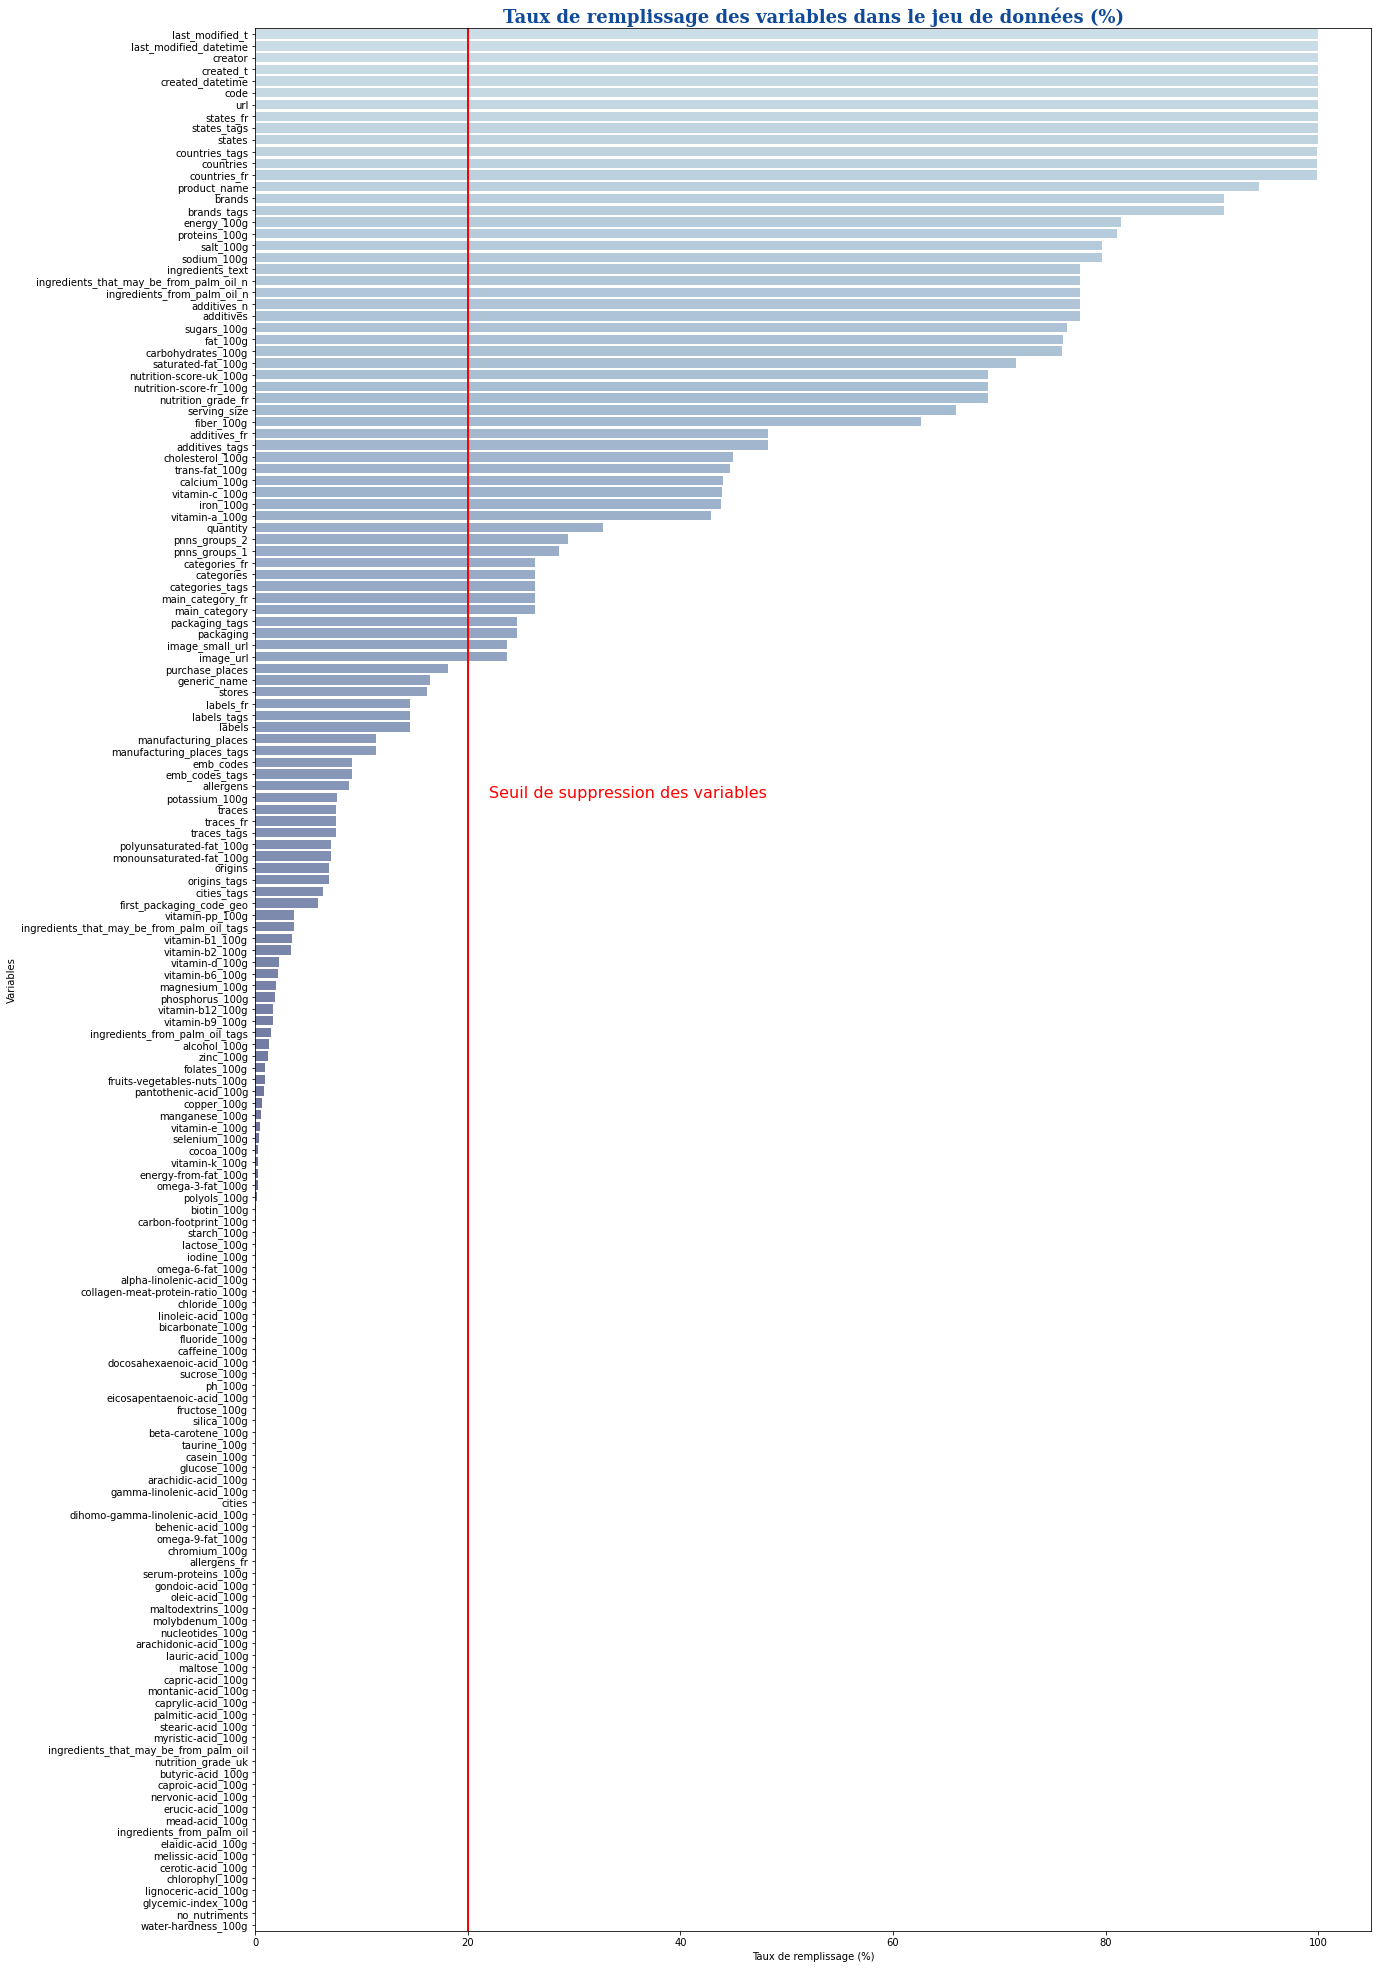

In [8]:
# Representation graphique

#Seuil de suppression
sup_threshold = 20

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_remplissage", y="Variables", data=taux_de_remplissage, palette="ch:s=.25,rot=-.25")
#Ligne indiquand le seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()


In [9]:
#Dataset avec les variables dont le taux de remplissage est suppérieur au seuil choisi
variable_a_conserver = list(taux_de_remplissage.loc[taux_de_remplissage['Taux_de_remplissage']>sup_threshold, 'Variables'].values)
df = df[variable_a_conserver]
df.head()

,last_modified_t,last_modified_datetime,creator,created_t,created_datetime,code,url,states_fr,states_tags,states,...,pnns_groups_1,categories_fr,categories,categories_tags,main_category_fr,main_category,packaging_tags,packaging,image_small_url,image_url
0,1474103893,2016-09-17T09:18:13Z,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,"A compléter,Informations nutritionnelles à com...","en:to-be-completed,en:nutrition-facts-to-be-co...","en:to-be-completed, en:nutrition-facts-to-be-c...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1489069957,2017-03-09T14:32:37Z,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,"A compléter,Informations nutritionnelles compl...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1489069957,2017-03-09T14:32:37Z,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,"A compléter,Informations nutritionnelles compl...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1489055731,2017-03-09T10:35:31Z,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,"A compléter,Informations nutritionnelles compl...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1489055653,2017-03-09T10:34:13Z,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,"A compléter,Informations nutritionnelles compl...","en:to-be-completed,en:nutrition-facts-complete...","en:to-be-completed, en:nutrition-facts-complet...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Après suppression des colonnes dont le taux de remplissage est inferieur à 20%, il ne reste que 54 colonnes dans notre dataset. Nous allons maintenant analyser les lignes qui ne contiennent que des valeurs nulles

In [10]:
print(f'Il y a {df.isnull().all(axis=1).sum()} lignes vides dans le dataset')

Il y a 0 lignes vides dans le dataset


Vue qu'il n y a aucune ligne, toutes colonnes confondues, ne contenant que des valeurs nulles, nous allons restreindre le dataset à certaines colonnes qui semblent pertinentes pour l'analyse

In [11]:
def verification_suffix(df, suffix='100_g'):
  colonnes_avec_suffix = []
  for col in df.columns:
      if suffix in col: colonnes_avec_suffix.append(col)
  df_sous_columns = df[colonnes_avec_suffix]
  return df_sous_columns

In [12]:
df_suffix_100g = verification_suffix(df,'_100g')
df_suffix_100g.head()

,energy_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-uk_100g,nutrition-score-fr_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2243.0,3.57,0.00000,0.000,14.29,28.57,64.29,28.57,14.0,14.0,3.6,0.018,0.0,0.000,0.0214,0.00129,0.0
2,1941.0,17.86,0.63500,0.250,17.86,17.86,60.71,0.00,0.0,0.0,7.1,0.000,0.0,0.071,0.0000,0.00129,0.0
3,2540.0,17.86,1.22428,0.482,3.57,57.14,17.86,5.36,12.0,12.0,7.1,NaN,NaN,0.143,NaN,0.00514,NaN
4,1552.0,8.57,NaN,NaN,NaN,1.43,77.14,NaN,NaN,NaN,5.7,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
print(f'Il y a {df_suffix_100g.isnull().all(axis=1).sum()} lignes vides dans le sous dataset')

Il y a 57939 lignes vides dans le sous dataset


In [14]:
# Dimensions du dataset avant suppression des lignes nulles
df.shape

(320772, 54)

In [15]:
# Suppression des lignes vides dans le dataset
# Dimensions du nouveau dataset
df = df[df_suffix_100g.notnull().any(axis=1)]
df.shape


(262833, 54)

### **2.3.&nbsp;Variables redondantes**
Certaines variables dans le dataset sont en réalité des variables redondantes. C'est par exemple le cas des variables suffixées par _tags ou _fr qui ne font que reprendre d'autres colonnes traduites ou simplifiées.

In [16]:
colonnes_categories = ['categories','categories_tags','categories_fr']
df[df[colonnes_categories].notnull().any(axis=1)][['product_name'] + colonnes_categories].sample(5)

,product_name,categories,categories_tags,categories_fr
220855,Graines de chanvre,Graines,"en:plant-based-foods-and-beverages,en:plant-ba...","Aliments et boissons à base de végétaux,Alimen..."
301289,Kinder Cards Céréales,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Bis...","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...","Snacks sucrés,Biscuits et gâteaux,Biscuits,Gau..."
69105,Camomile & Spiced apple tea,"Aliments et boissons à base de végétaux,Boisso...","en:plant-based-foods-and-beverages,en:beverage...","Aliments et boissons à base de végétaux,Boisso..."
225252,Cankao,"Boissons,Boissons chaudes,Boissons édulcorées,...","en:beverages,en:hot-beverages,en:artificially-...","Boissons,Boissons chaudes,Boissons édulcorées,..."
261849,Protein Riegel Kokos-Mandel,Proteinriegel,"en:dietary-supplements,en:bodybuilding-supplem...","Compléments alimentaires,Compléments pour le B..."


On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous allons donc, lorsque la colonne suffixée _fr existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant _tags

In [17]:
def recherche_colonnes_redondantes(df):
  colonnes_redondantes = []
  for col in df.columns:
    if "_fr" in col:
      col_sans_fr = col.replace('_fr','')
      col_avec_tags = col.replace('_fr','_tags')
      if col_sans_fr in df.columns : 
        colonnes_redondantes.append(col_sans_fr)
      if col_avec_tags not in colonnes_redondantes:
        if col_avec_tags in df.columns : 
          colonnes_redondantes.append(col_avec_tags)
  
    if '_tags' in col:
      if col not in colonnes_redondantes:
        col_sans_tags = col.replace('_tags','')
        if col_sans_tags in df.columns :
          colonnes_redondantes.append(col)

  return colonnes_redondantes

In [18]:
#Liste des colonnes redondantes à supprimer
colonnes_redondantes = recherche_colonnes_redondantes(df)
colonnes_redondantes

['states',
 'states_tags',
 'countries_tags',
 'countries',
 'brands_tags',
 'additives',
 'additives_tags',
 'categories',
 'categories_tags',
 'main_category',
 'packaging_tags']

In [19]:
#Suppression des colonnes redondantes
df.drop(colonnes_redondantes, axis=1, inplace=True)
df.shape

(262833, 43)

Vue qu'on s'interesse au cas de la France, nous allons supprimer la colonne **nutrition-score-uk_100g**

In [20]:
df = df.drop(['nutrition-score-uk_100g'], axis=1)
df.shape

(262833, 42)

Les dates aussi comportent de la redondance, les mêmes dates sous présentes sous différents formats : 

*   unix timestamp
*   iso8601

Nous allons donc supprimer celles sous format uniux timestamp



In [21]:
df = df.drop(['created_t','last_modified_t'], axis=1)
df.shape

(262833, 40)

### **2.4.&nbsp;Recherche et suppression des doublons**
Nous allons identifier les doublons et les supprimer 

In [22]:
#Suppression des doublons en fonction du code
df.drop_duplicates(subset="code", keep = 'last', inplace=True)
df.shape

(262818, 40)

In [23]:
#Nombre de potentiels de doublons par nom de produit et marque
df[(df["product_name"].isnull()==False) & (df["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

product_name                                               brands                                                                               
Icing Decorations                                          Wilton,  Wilton Enterprises Inc                                                          36
Premium Ice Cream                                          Weis                                                                                     35
Coca-Cola                                                  Coca-Cola                                                                                33
Icing Decorations                                          Wilton                                                                                   28
Aceite de oliva virgen extra &quot;Esencia Andalusí&quot;  Esencia Andalusí,//Propiedad de://,José Serrano López (Esencia Andalusí Gourmet S.L.)    23
                                                                                                    

In [24]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
df = df[(~df.duplicated(["product_name","brands"],keep="last")) | ((df['product_name'].isnull()) & (df['brands'].isnull()))]
df.shape

(244366, 40)

In [25]:
df[(df["product_name"].isnull()==False) & (df["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

product_name                                       brands       
  Bridelight 3% Les carrés fondants goût Emmental  Bridelight       1
Pepperoncini Peppers                               Vlasic           1
Pepperoncini                                       Colonna          1
                                                   Cora             1
                                                   Divina           1
                                                                   ..
Frites au Four L'Allumette                         Findus           1
Frites au Four, Préfrites et Surgelées             Mr Frites        1
Frites au four                                     Carrefour        1
                                                   Carrefour Bio    1
콩두유                                                빙그레              1
Name: code, Length: 237992, dtype: int64

### **2.5.&nbsp;Analyse des categories**
Nous allons maintenant nous intéresser à la catégorie des produits qui est représentée par 4 colonnes

In [26]:
df[['categories_fr','pnns_groups_1','pnns_groups_2','main_category_fr',]].sample(10)

,categories_fr,pnns_groups_1,pnns_groups_2,main_category_fr
145178,NaN,NaN,NaN,NaN
112251,NaN,NaN,NaN,NaN
216372,NaN,NaN,NaN,NaN
297996,NaN,NaN,NaN,NaN
106539,NaN,NaN,NaN,NaN
316343,NaN,NaN,NaN,NaN
17658,NaN,NaN,NaN,NaN
261898,"Aliments et boissons à base de végétaux,Boisso...",Beverages,Non-sugared beverages,Boissons
307778,"Aliments et boissons à base de végétaux,Alimen...",Fruits and vegetables,Vegetables,Pickles
156215,NaN,NaN,NaN,NaN


Nous allons nous intéresser au nombre total de catégories

In [27]:
#Fonction qui permet de séparer les mots
def separation_mots(df, column = 'categories_fr'):
  liste_de_mots = set()
  for mots in df[column].str.split(','):
    if isinstance(mots, float):
      continue
    liste_de_mots = set().union(mots, liste_de_mots)
  return list(liste_de_mots)

In [28]:
#Nombre total de catégories
categories = separation_mots(df = df, column = 'categories_fr')
print(f'{len(categories)} catégories sont représentées dans le jeu de données')

11122 catégories sont représentées dans le jeu de données


Nous allons maintenant nous intéresser aux catégories les plus représentées

In [29]:
df['categories_fr'] = np.where((df['categories_fr'].isnull()==True), "inconnu", np.where(df['categories_fr'] == "", "inconnu", df['categories_fr']))
df['main_category_fr'] = np.where((df['main_category_fr'].isnull()==True), "inconnu", np.where(df['main_category_fr'] == "", "inconnu", df['main_category_fr']))
df['pnns_groups_1'] = np.where((df['pnns_groups_1'].isnull()==True), "inconnu", np.where(df['pnns_groups_1'] == "", "inconnu", df['pnns_groups_1']))
df['pnns_groups_2'] = np.where((df['pnns_groups_2'].isnull()==True), "inconnu", np.where(df['pnns_groups_2'] == "", "inconnu", df['pnns_groups_2']))

In [30]:
#Fonctions pour visualiser les catégories les plus représentées
def top_mots(df, column="categories_fr", nb_top=10):
  decompte_mots = dict()
  for i, col in df[column].iteritems():
    if isinstance(col, float):
      continue
    for mots in col.split(','):
      if mots in decompte_mots.keys():
        decompte_mots[mots] += 1
      else :
        decompte_mots[mots] = 1
  
  list_top_mots = []
  for k,v in decompte_mots.items():
    list_top_mots.append([k,v])
  list_top_mots.sort(key = lambda x:x[1], reverse = True)

  return list_top_mots[:nb_top]

from wordcloud import WordCloud

def graphe_world_cloud(df=df,column="categories_fr",nb_top=100):
  fig = plt.figure(1, figsize=(20,15))
  ax1 = fig.add_subplot(1,1,1)

  mots = dict()
  occurences = top_mots(df=df, column=column, nb_top=nb_top)
  for s in occurences:
    mots[s[0]] = s[1]

  word_cloud = WordCloud(width=900,height=500, normalize_plurals=False,
                        background_color="white")
  word_cloud.generate_from_frequencies(mots)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des {} meilleures {}\n".format(nb_top, column), fontsize=22)
  plt.show()

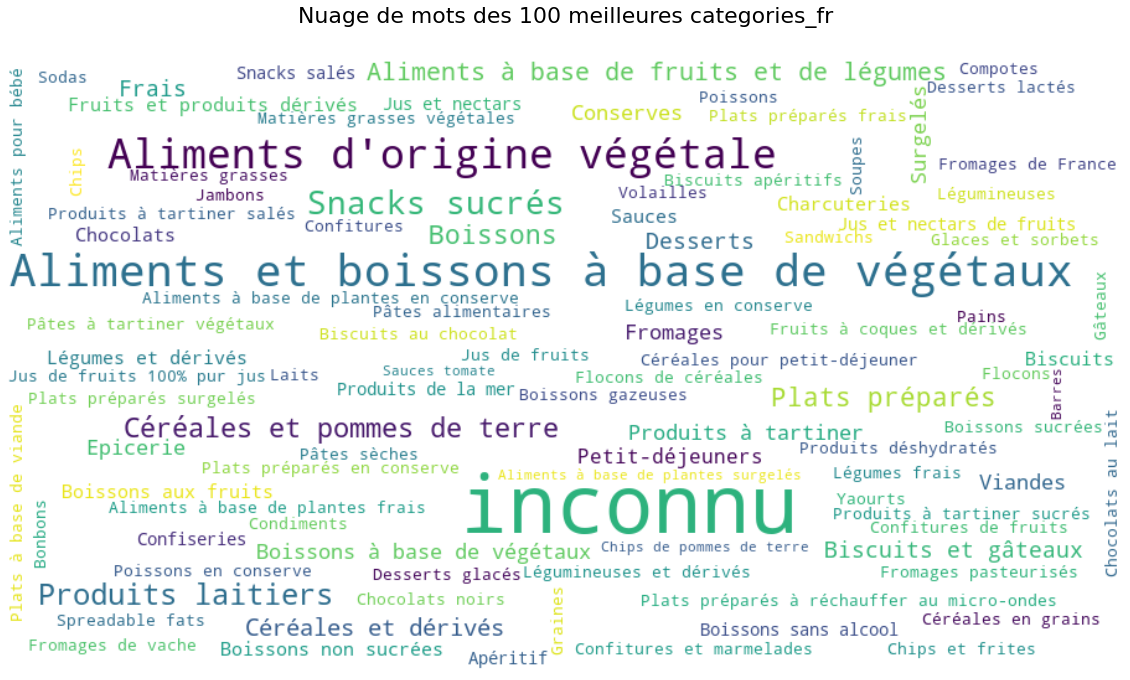

In [31]:
graphe_world_cloud(df=df,column="categories_fr",nb_top=100)

Nous allons nous intéresser aux colonnes pnns_groups_1 et pnns_groups_2 qui nous donnent plus de précision sur la catégorie des produits

In [32]:
pnns_groups_1 = separation_mots(df = df, column = 'pnns_groups_1')
pnns_groups_2 = separation_mots(df = df, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

15 catégories sont représentées dans la variable pnns_group_1.
43 catégories sont représentées dans la variable pnns_group_2.


In [33]:
pnns_groups_1

['inconnu',
 'Fat and sauces',
 'Fruits and vegetables',
 'fruits-and-vegetables',
 'sugary-snacks',
 'Cereals and potatoes',
 'Fish Meat Eggs',
 'Salty snacks',
 'Composite foods',
 'salty-snacks',
 'unknown',
 'Beverages',
 'Sugary snacks',
 'cereals-and-potatoes',
 'Milk and dairy products']

Certaines catégories sont redondantes

*   Fruits and vegetables et fruits-and-vegetables
*   Cereals and potatoes et cereals-and-potatoes


In [34]:
df["pnns_groups_1"] = df["pnns_groups_1"].str.lower().str.replace('-', ' ')
pnns_groups_1 = separation_mots(df = df, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))

11 catégories sont représentées dans la variable pnns_group_1.


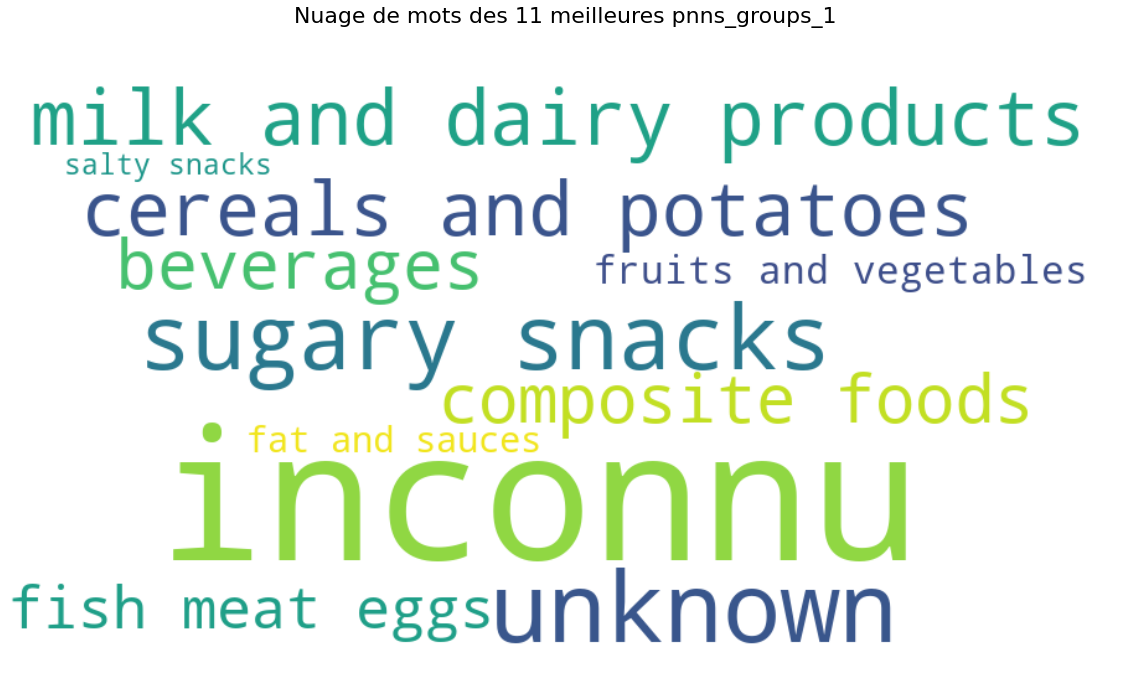

In [35]:
graphe_world_cloud(df=df,column="pnns_groups_1",nb_top=len(pnns_groups_1))

In [36]:
pnns_groups_2

['inconnu',
 'Sweets',
 'Alcoholic beverages',
 'Bread',
 'Artificially sweetened beverages',
 'cereals',
 'Appetizers',
 'pastries',
 'One-dish meals',
 'Fruit juices',
 'Salty and fatty products',
 'unknown',
 'Milk and yogurt',
 'Soups',
 'Potatoes',
 'Processed meat',
 'Sweetened beverages',
 'Breakfast cereals',
 'Tripe dishes',
 'Sandwich',
 'Eggs',
 'Vegetables',
 'Dressings and sauces',
 'Cheese',
 'legumes',
 'Ice cream',
 'Fruits',
 'Meat',
 'Non-sugared beverages',
 'Fats',
 'Nuts',
 'Dairy desserts',
 'fruits',
 'Dried fruits',
 'Pizza pies and quiche',
 'Legumes',
 'Chocolate products',
 'Fruit nectars',
 'Biscuits and cakes',
 'Cereals',
 'nuts',
 'Fish and seafood',
 'vegetables']

In [37]:
df["pnns_groups_2"] = df["pnns_groups_2"].str.lower().str.replace('-', ' ')
pnns_groups_2 = separation_mots(df = df, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

38 catégories sont représentées dans la variable pnns_group_2.


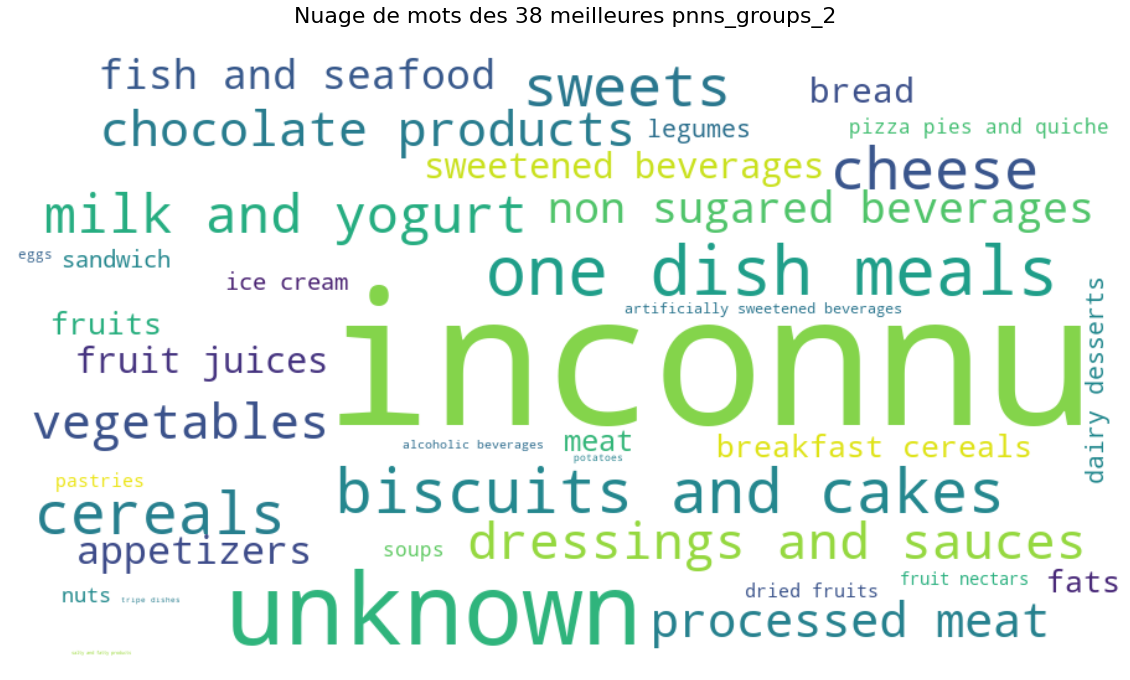

In [38]:
graphe_world_cloud(df=df,column="pnns_groups_2",nb_top=len(pnns_groups_2))


A la suite de l'analyse des catégories, on se rend la majeur partie des catégories est inconnu

### **2.6.&nbsp;L'idée de l'application**

Notre idée d'application est de fournir un score qui reprend les variables de la méthode classique du calcul du ntriscore mais qui met l'accent sur le taux de sucre des produits que l'on souhaite donner aux petits enfants, et aussi faire des recommendations de produits de la même catégories.  
La valeur ajoutée de notre application est qu'elle se positionne en complément du nutrigrade dans la mesure où certains produits ont une bonne note mais contiennent un taux de sucre trop élevé pour les petits enfants. Selon l'OMS **un taux de 12g par jour** est recommandé [creapharma](https://www.creapharma.ch/news/quantite-sucre-depasser-jour.htm).  
Nous ne prenons en compte que quelques catégories liées à l'alimentation des petits enfants

In [40]:
#'pnns_groups_1', 'pnns_groups_2' colonnes à utiliser pour le filtrage
df_filtre = df.loc[(df['countries_fr'].str.contains("France", case=False)) & (df['categories_fr'].str.contains("Snacks|Tartiner|Petit-déjeuners|Fruits|Fruit|Compotes|Compote|Desserts|Bonbons|Biscuits|Gateaux|Patisseries|Lait|Milk|Boisson|Boissons|Sirop|Sirops|Jus|Soda|Beverage|Beverages|Drink|Drinks|Juice|Juices|Yaourt|Yaourts|Sucrées|Sucrés|Céréals|Yoghourt|Yoghourts|Cereals|Chocolat|Chocolate", case=False)) & ~(df['categories_fr'].str.contains("Alcool|Alcools|Alcohol|Alcohols|alcoolisées|Bières|alcoolisée|Bière|Alcoolisées|bières|Alcoolisée|bière", case=False))]
print(f'Le dataset filtré sur la base des catégories de produits alimentaires pour enfants contient {df_filtre.shape[0]} lignes et {df_filtre.shape[1]} colonnes')

#Nous selectionnons quelques colonnes pertinentes pour justifier notre idée d'application
df_filtre_colonne = df_filtre[['product_name', 'categories_fr', 'nutrition-score-fr_100g', 'nutrition_grade_fr', 'sugars_100g', 'quantity']]

#Nous montrons en effet que certains produits ont un bon nutrigrade avec par contre un taux de sucre au delà du seuil tolerable recommandé(3g) pour les enfants
df_filtre_colonne = df_filtre_colonne[df_filtre_colonne['sugars_100g'].notna() & df_filtre_colonne['sugars_100g'].ge(3) & df_filtre_colonne['nutrition_grade_fr'].le('c') ]
print(f'Le dataset filtré sur la base du taux de sucre superieur à 3g et le nutrigrade entre a et c contient {df_filtre_colonne.shape[0]} lignes et {df_filtre_colonne.shape[1]} colonnes')
df_filtre_colonne.head(100)


Le dataset filtré sur la base des catégories de produits alimentaires pour enfants contient 30295 lignes et 40 colonnes
Le dataset filtré sur la base du taux de sucre superieur à 3g et le nutrigrade entre a et c contient 8299 lignes et 6 colonnes


,product_name,categories_fr,nutrition-score-fr_100g,nutrition_grade_fr,sugars_100g,quantity
11332,Pistaches grillées sans sel Wonderful,"Aliments et boissons à base de végétaux,Alimen...",3.0,c,7.80,250 g
13108,Jackfruit in syrup,"Aliments et boissons à base de végétaux,Alimen...",0.0,b,17.86,565 g
13136,NaN,Jus-de-noix-de-coco,1.0,b,8.75,520 ml
13149,Soupe Tom Yum aux légumes,"Aliments et boissons à base de végétaux,Alimen...",1.0,b,3.33,300 g
14734,Macaroni N' Cheese,"Aliments et boissons à base de végétaux,Alimen...",9.0,c,7.05,206 g
...,...,...,...,...,...,...
176072,Crunchy,"Aliments et boissons à base de végétaux,Alimen...",0.0,b,18.80,1kg
176076,Leader price fine ligne,"Aliments et boissons à base de végétaux,Alimen...",10.0,c,42.00,340 g
176077,Yaourt de brebis nature - Bio Casino,"Produits laitiers,Yaourts,Yaourts au lait de b...",-1.0,a,3.00,125 g
176103,Les Moulinés de Fruits Pomme Ananas,"Aliments et boissons à base de végétaux,Alimen...",-3.0,a,12.90,100 g e


### **2.7.&nbsp;Gestion des valeurs manquantes et aberrantes**

In [41]:
df_filtre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30295 entries, 226 to 320763
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   last_modified_datetime                   30295 non-null  object 
 1   creator                                  30295 non-null  object 
 2   created_datetime                         30294 non-null  object 
 3   code                                     30295 non-null  object 
 4   url                                      30295 non-null  object 
 5   states_fr                                30295 non-null  object 
 6   countries_fr                             30295 non-null  object 
 7   product_name                             30221 non-null  object 
 8   brands                                   30207 non-null  object 
 9   energy_100g                              29750 non-null  float64
 10  proteins_100g                            29

Le dataset contient plusieurs colonnes avec des valeurs manquantes qu'il nous faut gérer

In [42]:
df_filtre.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
count,29750.000000,29584.000000,28568.000000,28566.000000,26988.000000,26988.000000,26988.000000,28593.000000,28255.000000,27916.000000,28477.000000,28001.000000,19466.000000,263.000000,248.000000,1865.000000,590.000000,848.000000,343.000000
mean,1251.165949,6.585337,0.709992,0.279542,0.180673,0.098414,1.940788,16.701544,14.706101,35.178023,6.379452,8.962716,3.206550,0.053468,0.264129,0.329713,0.029393,0.056958,0.000678
std,834.811559,6.460211,2.969478,1.168991,0.501934,0.302937,2.577005,19.990266,18.360763,28.603817,9.403878,9.606982,4.263591,0.672211,1.208961,1.835238,0.058171,0.893175,0.006469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,1.600000,0.030000,0.011811,0.000000,0.000000,0.000000,1.800000,1.000000,6.000000,0.200000,1.000000,0.500000,0.000000,0.000000,0.120000,0.010000,0.003000,0.000063
50%,1370.000000,5.400000,0.230000,0.090551,0.000000,0.000000,1.000000,7.000000,7.140000,33.350000,2.100000,10.000000,2.100000,0.000000,0.000000,0.130000,0.014000,0.006000,0.000200
75%,1857.000000,8.700000,0.920000,0.362205,0.000000,0.000000,3.000000,27.000000,24.000000,61.000000,10.300000,16.000000,4.200000,0.001000,0.200000,0.350000,0.032000,0.008000,0.000602
max,18700.000000,93.100000,211.000000,83.000000,5.000000,2.000000,31.000000,105.000000,380.000000,190.000000,210.000000,40.000000,86.200000,10.900000,17.200000,69.500000,1.200000,25.000000,0.120000


In [43]:
df_filtre[df_filtre['energy_100g'] == df_filtre['energy_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
245311,2017-04-07T21:58:05Z,bonifacefr,2014-08-09T15:52:34Z,3596710288755,http://world-fr.openfoodfacts.org/produit/3596...,"A compléter,Informations nutritionnelles compl...",France,mini choux goût fromage de chèvre - poivre,Auchan,18700.0,...,NaN,NaN,60 g,appetizers,salty snacks,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",Snacks salés,"étui carton,film plastique",NaN,NaN


In [44]:
df_filtre[df_filtre['fat_100g'] == df_filtre['fat_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
245311,2017-04-07T21:58:05Z,bonifacefr,2014-08-09T15:52:34Z,3596710288755,http://world-fr.openfoodfacts.org/produit/3596...,"A compléter,Informations nutritionnelles compl...",France,mini choux goût fromage de chèvre - poivre,Auchan,18700.0,...,NaN,NaN,60 g,appetizers,salty snacks,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",Snacks salés,"étui carton,film plastique",NaN,NaN


In [45]:
df_filtre[df_filtre['saturated-fat_100g'] == df_filtre['saturated-fat_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
245311,2017-04-07T21:58:05Z,bonifacefr,2014-08-09T15:52:34Z,3596710288755,http://world-fr.openfoodfacts.org/produit/3596...,"A compléter,Informations nutritionnelles compl...",France,mini choux goût fromage de chèvre - poivre,Auchan,18700.0,...,NaN,NaN,60 g,appetizers,salty snacks,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",Snacks salés,"étui carton,film plastique",NaN,NaN


In [46]:
df_filtre[df_filtre['carbohydrates_100g'] == df_filtre['carbohydrates_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
245311,2017-04-07T21:58:05Z,bonifacefr,2014-08-09T15:52:34Z,3596710288755,http://world-fr.openfoodfacts.org/produit/3596...,"A compléter,Informations nutritionnelles compl...",France,mini choux goût fromage de chèvre - poivre,Auchan,18700.0,...,NaN,NaN,60 g,appetizers,salty snacks,"Snacks salés,Apéritif,Biscuits apéritifs,Produ...",Snacks salés,"étui carton,film plastique",NaN,NaN


On se rend compte que le même produit (code = 3596710288755) à une valeur maximale dans plusieurs colonnes energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g. Ces différentes valeurs s'averrent être des valeurs abérrantes.

In [47]:
df_filtre[df_filtre['salt_100g'] == df_filtre['salt_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
232239,2017-02-01T21:21:33Z,bea51,2016-09-23T12:21:10Z,3423720002432,http://world-fr.openfoodfacts.org/produit/3423...,"A compléter,Informations nutritionnelles compl...",France,Keeny Bio,Bio Soleil,1720.0,...,NaN,NaN,135 g,biscuits and cakes,sugary snacks,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",Gâteaux,Paquet individuel,NaN,NaN


On constate qu'un biscuit sucré a une valeur max en sel de 211g pour 100g de produit, cela semble être une erreur.

In [49]:
df_filtre[df_filtre['sugars_100g'] == df_filtre['sugars_100g'].max()]

,last_modified_datetime,creator,created_datetime,code,url,states_fr,countries_fr,product_name,brands,energy_100g,...,iron_100g,vitamin-a_100g,quantity,pnns_groups_2,pnns_groups_1,categories_fr,main_category_fr,packaging,image_small_url,image_url
239347,2017-03-10T11:23:31Z,sebleouf,2015-02-09T17:21:01Z,3560070740338,http://world-fr.openfoodfacts.org/produit/3560...,"A vérifier,Complet,Informations nutritionnelle...",France,Sirop d'agave,Carrefour Bio,1785.0,...,NaN,NaN,250 ml,sweets,sugary snacks,"Produits à tartiner,Petit-déjeuners,Produits à...",Produits à tartiner sucrés,"Flacon,Plastique,flacon",http://fr.openfoodfacts.org/images/products/35...,http://fr.openfoodfacts.org/images/products/35...


On constate que le sirop d'aggave a une valeur max en sucre de 105g pour 100g de produit, comme dans le cas précédent cela semble être une erreur.

## **2.7.1.&nbsp;Gestion des valeurs aberrantes**


Nous allons commencer par supprimer les produits dont les colonnes contiennent des valeurs négatives à l'exception de la colonne nutrition-score-fr_100g

In [51]:
colonnes_numeric = list(df_filtre.select_dtypes(include=["float64","int64"]).columns)
colonnes_numeric.remove('nutrition-score-fr_100g')
colonnes_numeric

['energy_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_from_palm_oil_n',
 'additives_n',
 'sugars_100g',
 'fat_100g',
 'carbohydrates_100g',
 'saturated-fat_100g',
 'fiber_100g',
 'cholesterol_100g',
 'trans-fat_100g',
 'calcium_100g',
 'vitamin-c_100g',
 'iron_100g',
 'vitamin-a_100g']

In [52]:
#On supprime les lignes contenant des valeurs negatives
df_filtre = df_filtre[~(df_filtre[colonnes_numeric] < 0).any(axis=1)]
df_filtre.shape

(30294, 40)

Les colonnes suffixées avec _100g nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs ne peuvent donc pas être supérieur à 100.

In [53]:
#On supprime les lignes dont les valeurs sont superieur à 100 | Y a t il pas une autre alternative?????
g_pour_100g = ['proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fiber_100g', 'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g', 'iron_100g', 'vitamin-a_100g']
df_filtre = df_filtre[~(df_filtre[g_pour_100g] > 100).any(axis=1)]
df_filtre.shape

(30286, 40)

Selon [Wikipedia](https://en.wikipedia.org/wiki/Food_energy) la densité d'energie maximales pour 100g est de 3700 kJ/100g .

In [54]:
#Nous n'avons aucune ligne dont la variable energy_100g est supérieur à 3700
df_filtre = df_filtre[~(df_filtre['energy_100g'] > 3700)]
df_filtre.shape

(30200, 40)

In [55]:
df_filtre.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
count,29655.000000,29492.000000,28478.000000,28476.000000,26932.000000,26932.000000,26932.000000,28503.000000,28191.000000,27857.000000,28384.000000,27913.000000,19392.000000,260.000000,246.000000,1863.000000,589.000000,847.000000,342.000000
mean,1241.758792,6.599156,0.703877,0.277137,0.181011,0.098507,1.944081,16.723139,14.541487,35.212380,6.336110,8.943467,3.217778,0.053266,0.266276,0.329879,0.029443,0.057024,0.000679
std,809.468964,6.458172,2.699411,1.062842,0.502364,0.303071,2.578030,19.969683,17.895616,28.563064,9.239357,9.611348,4.267142,0.676004,1.213649,1.836208,0.058208,0.893701,0.006479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,414.000000,1.600000,0.030000,0.011811,0.000000,0.000000,0.000000,1.800000,1.000000,6.000000,0.200000,1.000000,0.500000,0.000000,0.000000,0.120000,0.010000,0.003000,0.000063
50%,1366.000000,5.400000,0.230000,0.090551,0.000000,0.000000,1.000000,7.100000,7.100000,33.700000,2.100000,10.000000,2.110000,0.000000,0.000000,0.130000,0.014000,0.006000,0.000195
75%,1851.000000,8.700000,0.929005,0.366000,0.000000,0.000000,3.000000,27.000000,24.000000,61.000000,10.200000,16.000000,4.200000,0.001000,0.200000,0.350000,0.032000,0.008000,0.000602
max,3700.000000,93.100000,100.000000,39.370079,5.000000,2.000000,31.000000,100.000000,100.000000,100.000000,100.000000,40.000000,86.200000,10.900000,17.200000,69.500000,1.200000,25.000000,0.120000


In [70]:
df_filtre.loc[df_filtre['sugars_100g'] == df_filtre['sugars_100g'].max(),['brands', 'product_name','pnns_groups_1','sugars_100g','nutrition-score-fr_100g','nutrition_grade_fr']]

,brands,product_name,pnns_groups_1,sugars_100g,nutrition-score-fr_100g,nutrition_grade_fr
193061,Lune de miel,Miel de Fleurs bio,sugary snacks,100.0,13.0,d
274992,Pimlico,Super Puff Candy Floss,sugary snacks,100.0,15.0,d
282404,AdMaR,Candy Floss,sugary snacks,100.0,15.0,d


Ces produits contiennent 100g de sucre pour 100g de produit, cependant il s'agit de miel et barbe à papa. Ces valeurs peuvent donc être considérées comme atypiques

In [71]:
df_filtre.loc[df_filtre['carbohydrates_100g'] == df_filtre['carbohydrates_100g'].max(),['brands', 'product_name', 'pnns_groups_1', 'carbohydrates_100g','nutrition-score-fr_100g','nutrition_grade_fr']]

,brands,product_name,pnns_groups_1,carbohydrates_100g,nutrition-score-fr_100g,nutrition_grade_fr
274992,Pimlico,Super Puff Candy Floss,sugary snacks,100.0,15.0,d
282404,AdMaR,Candy Floss,sugary snacks,100.0,15.0,d


Comme dans le cas précédent, la valeur de 100g de carbohydrates pour 100g de produit dans la barbe à papa peut être considéreée comme une valeur atypique

In [69]:
df_filtre.loc[df_filtre['salt_100g'] == df_filtre['salt_100g'].max(),['brands', 'product_name','salt_100g','nutrition-score-fr_100g','nutrition_grade_fr']]

,brands,product_name,salt_100g,nutrition-score-fr_100g,nutrition_grade_fr
196313,Ducros,Moulin Sel de Guérande,100.0,10.0,c
243550,Nos regions ont du talent,Sel fin de Guérande,100.0,10.0,c
243666,"Nos Régions ont du Talent,Leclerc",Sel Fin de l'Île de Ré,100.0,10.0,c


Avoir 100g de sel dans 100g de sel de Guérande, ou sel de l'île de Ré peut être considérée comme une valeur atypique

In [65]:
df_filtre.loc[df_filtre['fat_100g'] == df_filtre['fat_100g'].max(),['brands', 'product_name','pnns_groups_1','fat_100g','nutrition-score-fr_100g','nutrition_grade_fr']]

,brands,product_name,pnns_groups_1,fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
115021,Monini,Huile d'Olive Vierge Extra Classico,fat and sauces,100.0,11.0,d
175293,"Terre de Crète,Arnaud Gillet",Huile d'olive vierge extra - Crète - 2012,fat and sauces,100.0,NaN,NaN
177219,Vita d'Or,Frites & Fritures,fat and sauces,100.0,20.0,e
184439,Jog'Frit,Jog'Frit,fat and sauces,100.0,20.0,e
184443,Buttella,Huile de tournesol,fat and sauces,100.0,11.0,d
...,...,...,...,...,...,...
310663,Almas,Oli d'Olivier verge extra,fat and sauces,100.0,12.0,d
311909,Dia,Huile d'olive vierge extra Dia,fat and sauces,100.0,11.0,d
311910,Dia,Huile de tounesol,fat and sauces,100.0,11.0,d
311965,Dia,Huile de colza,fat and sauces,100.0,10.0,c


In [64]:
df_filtre.loc[df_filtre['saturated-fat_100g'] == df_filtre['saturated-fat_100g'].max(),['brands', 'product_name','pnns_groups_1','saturated-fat_100g','nutrition-score-fr_100g','nutrition_grade_fr']]

,brands,product_name,pnns_groups_1,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
177219,Vita d'Or,Frites & Fritures,fat and sauces,100.0,20.0,e
184439,Jog'Frit,Jog'Frit,fat and sauces,100.0,20.0,e
275205,Végétaline,Végétaline (offre familiale),fat and sauces,100.0,15.0,d


Comme dans les cas précédents, avoir 100g de matières grasses dans 100g d'huile ou de friture semble être une valeur atypique

## **2.7.2.&nbsp;Gestion des valeurs manquantes**


Nous allons maintenant nous interesser à la distribution des variables, selon qu'elles suivent la loi normale ou pas, nous appliquerons une méthode d'imputation adaptée

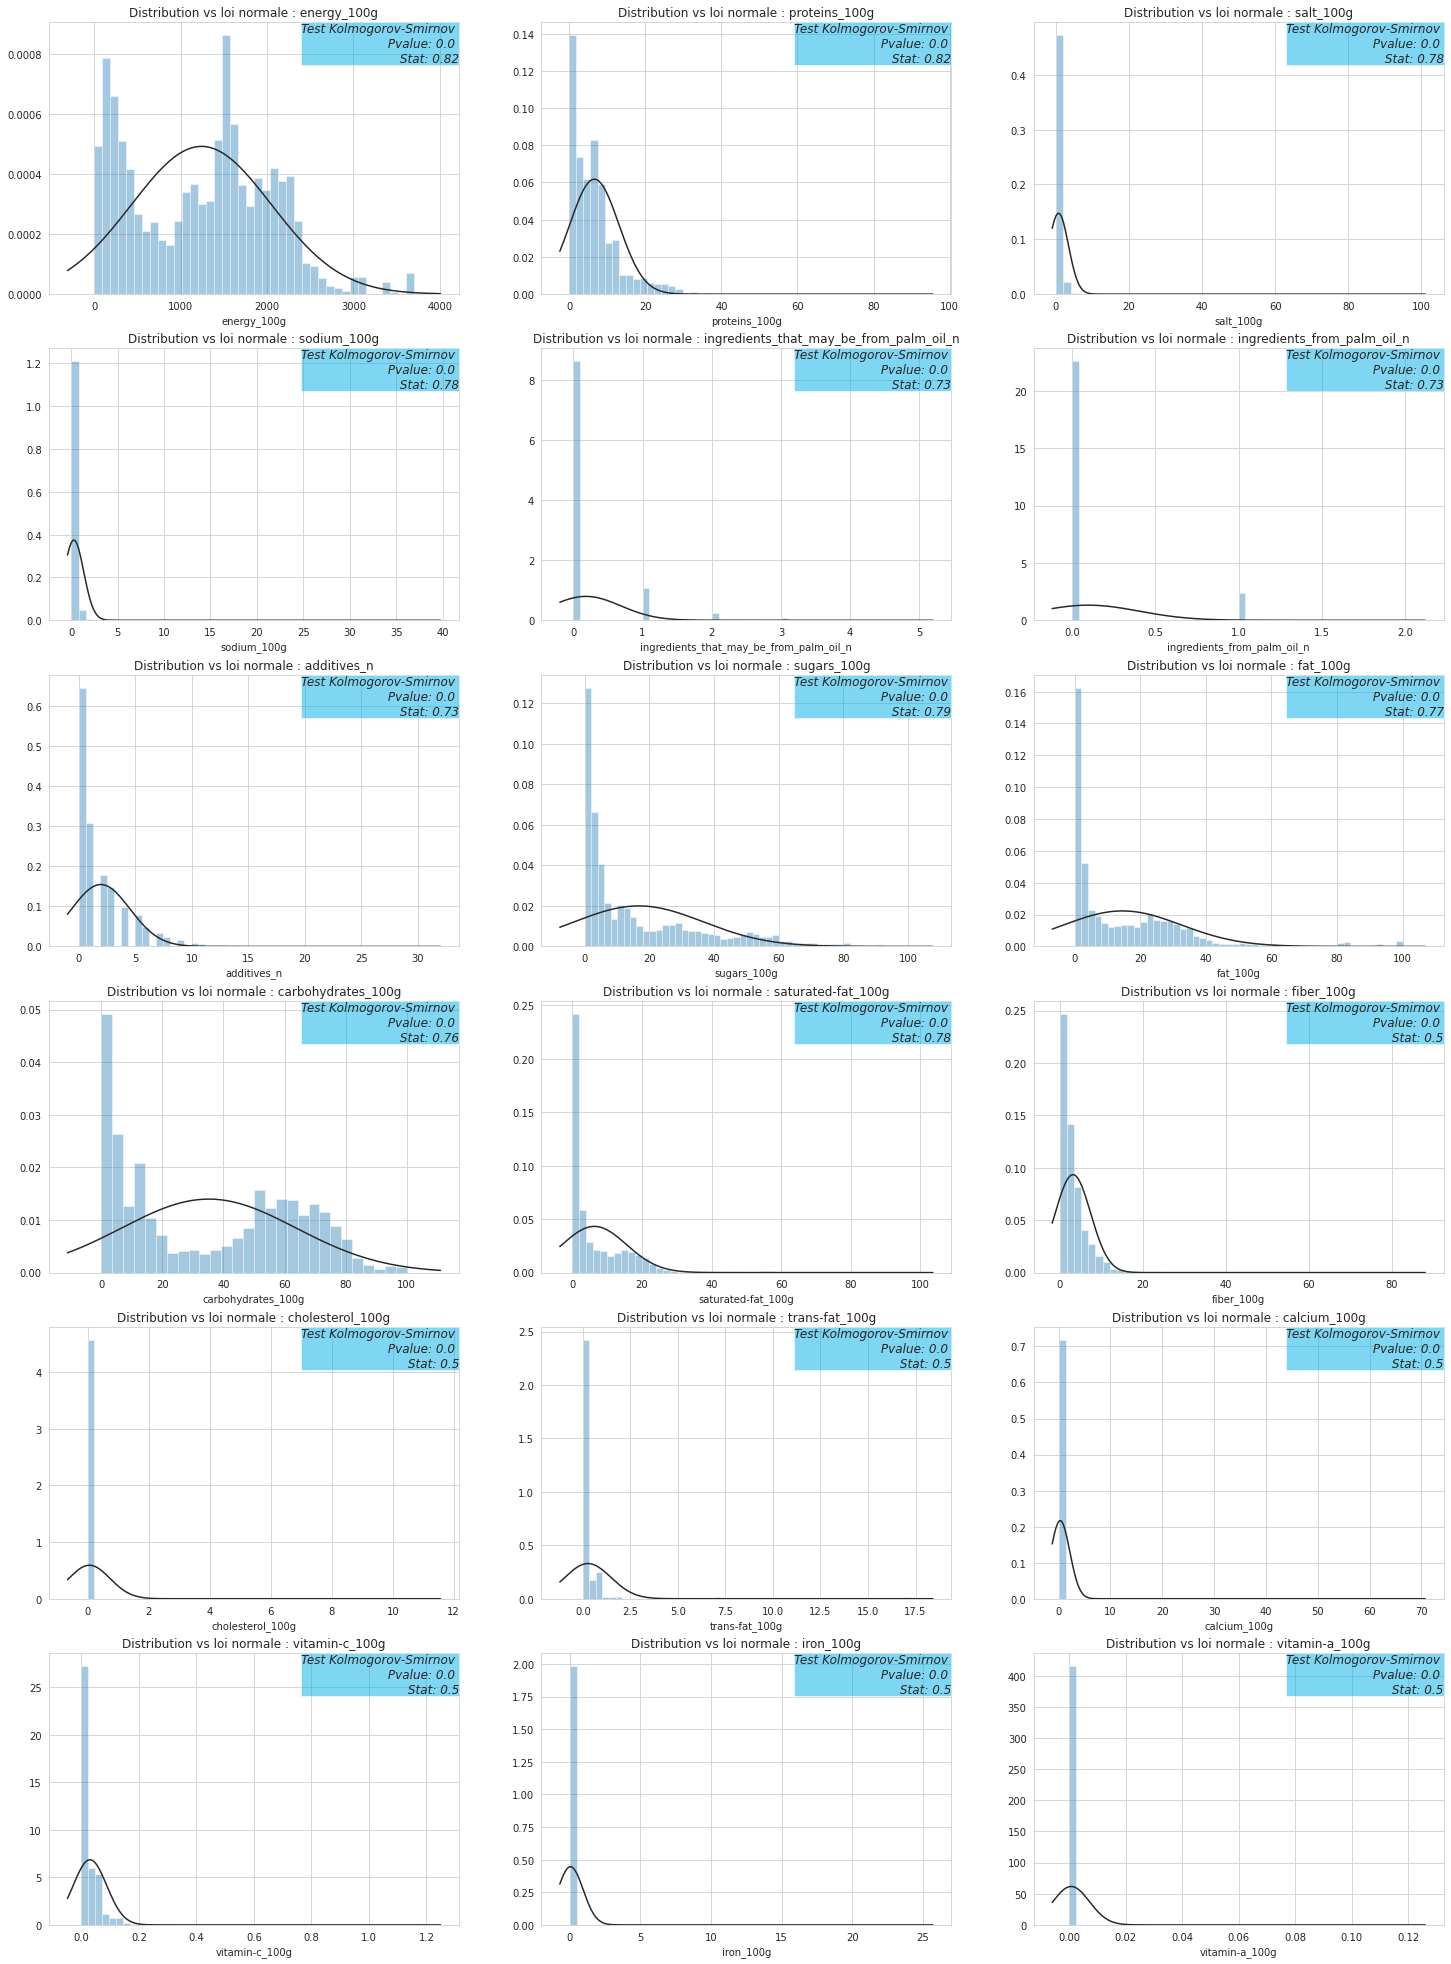

In [72]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(25,35))

sub = 0
for i in range(len(colonnes_numeric)):
    fig.add_subplot(6,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height

    colonne = colonnes_numeric[i]
    kstest = stats.kstest(df_filtre[colonne].notnull(),'norm')
    ax = sns.distplot(df_filtre[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
plt.show()
    

En se basant sur les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) on rejette donc l'hypothèse de normalité des distributions de ces variables. Il ne serait donc pas judicieux d'imputer les valeurs manquantes par la moyenne.  
Nous allons analyser la distribution en fonction des categories

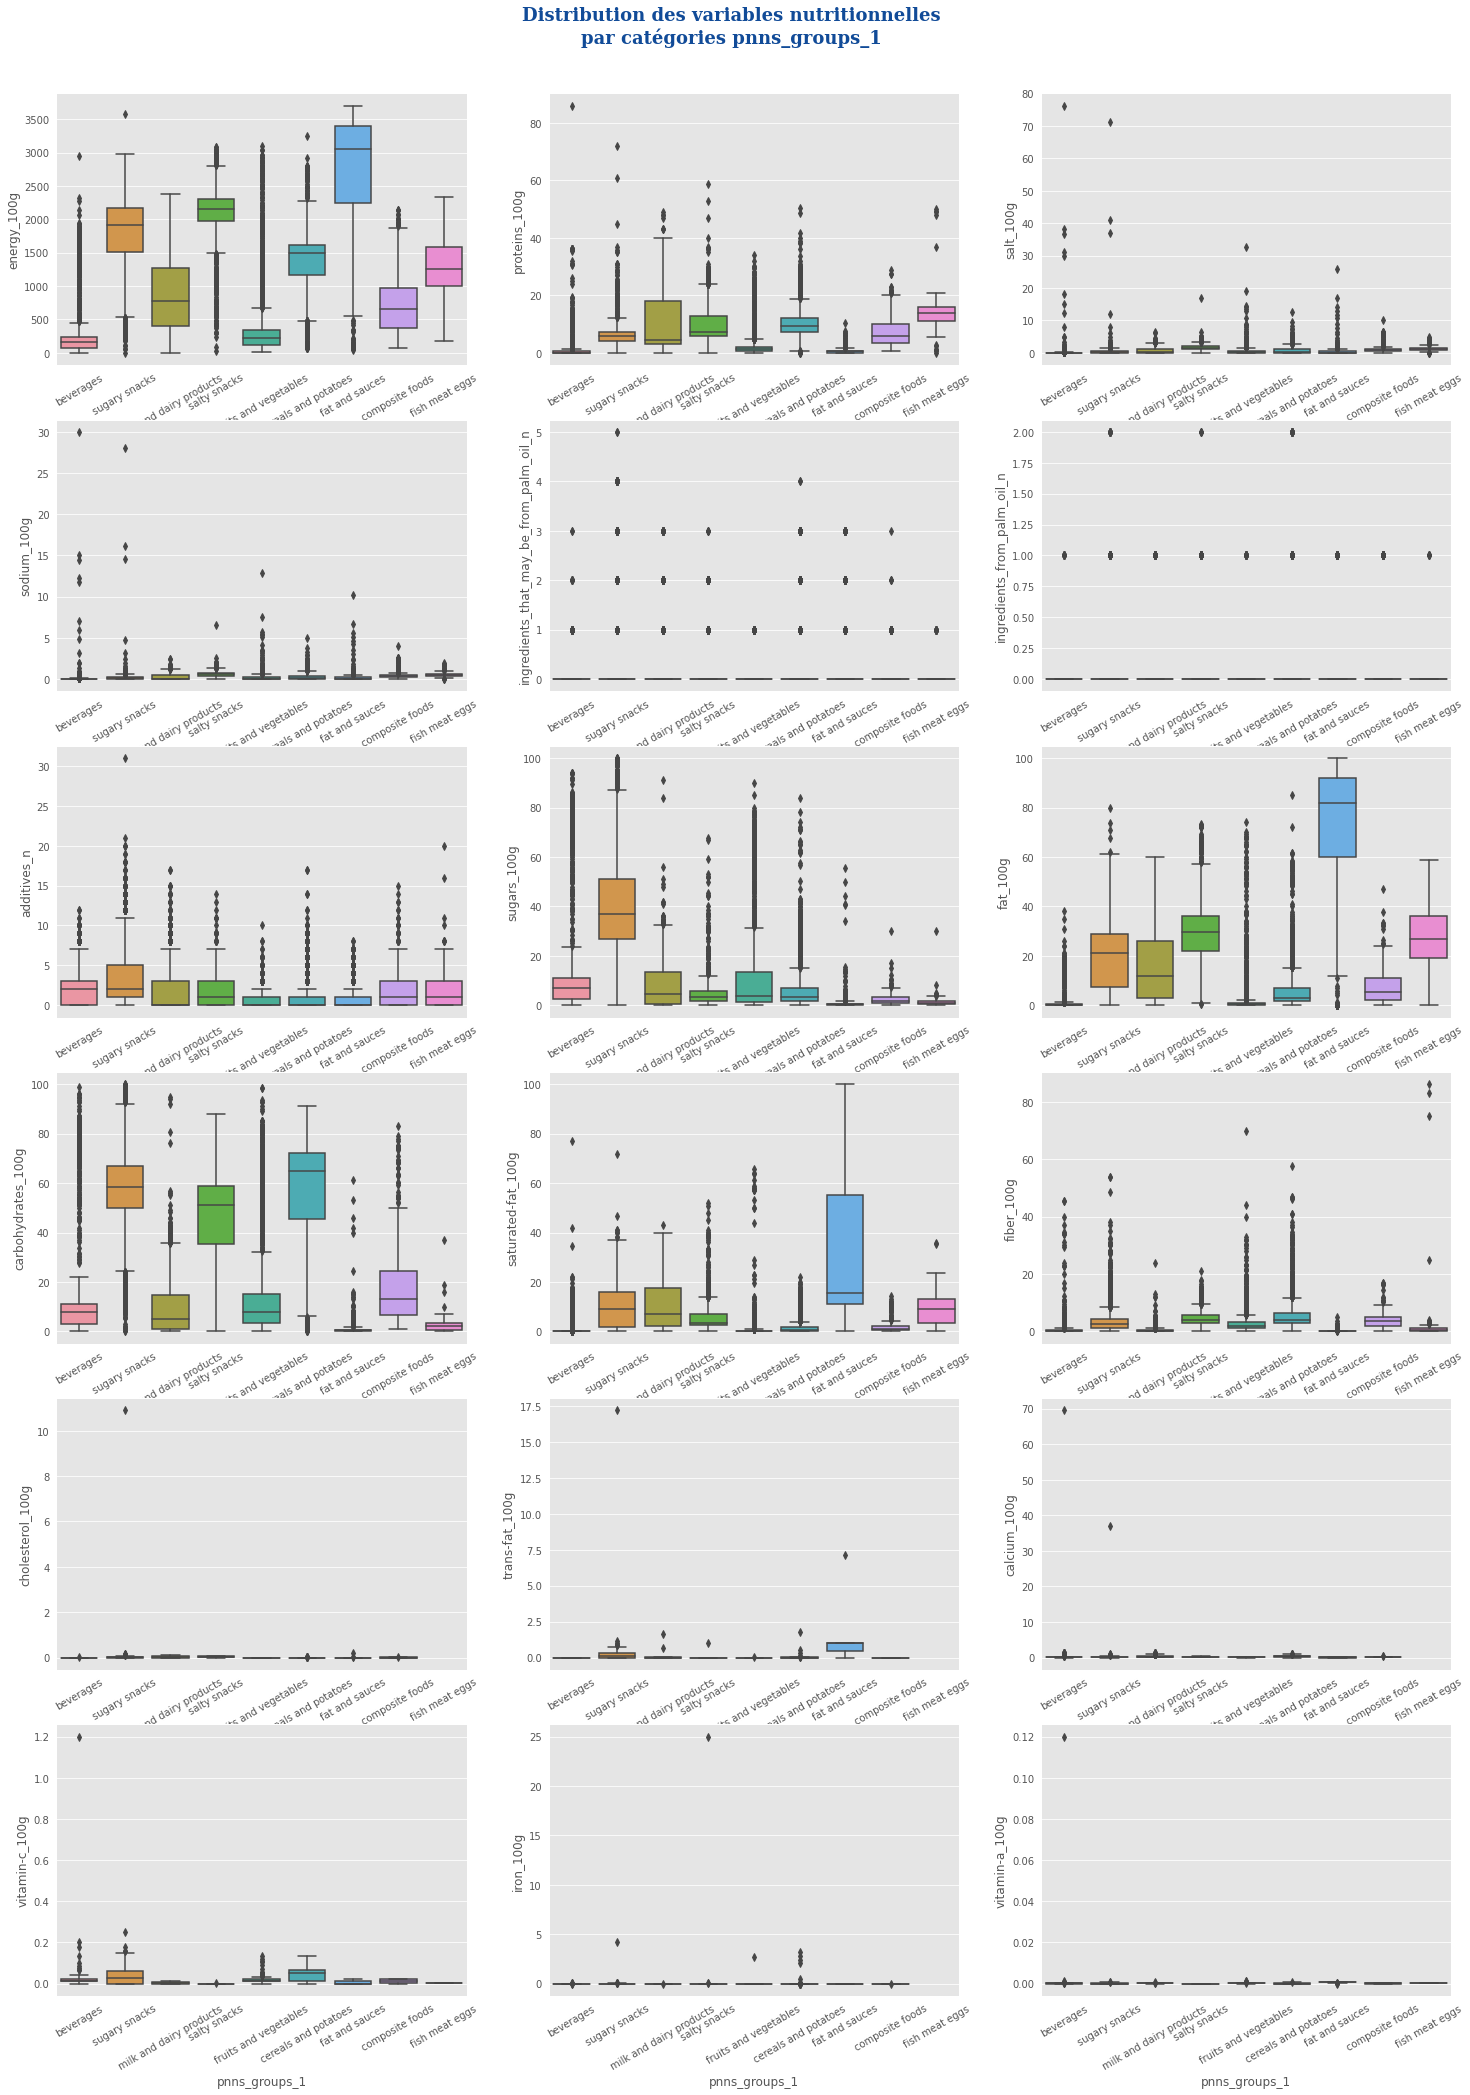

In [73]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(25,35))

sub = 0
for i in range(len(colonnes_numeric)):
    fig.add_subplot(6,3,i+1)
    colonne = colonnes_numeric[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=df_filtre[df_filtre["pnns_groups_1"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center", 
         fontdict=font_title)
plt.show()

In [74]:
df_filtre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 226 to 320763
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   last_modified_datetime                   30200 non-null  object 
 1   creator                                  30200 non-null  object 
 2   created_datetime                         30199 non-null  object 
 3   code                                     30200 non-null  object 
 4   url                                      30200 non-null  object 
 5   states_fr                                30200 non-null  object 
 6   countries_fr                             30200 non-null  object 
 7   product_name                             30126 non-null  object 
 8   brands                                   30112 non-null  object 
 9   energy_100g                              29655 non-null  float64
 10  proteins_100g                            29

In [75]:
df_filtre[colonnes_numeric].isnull().sum()

energy_100g                                  545
proteins_100g                                708
salt_100g                                   1722
sodium_100g                                 1724
ingredients_that_may_be_from_palm_oil_n     3268
ingredients_from_palm_oil_n                 3268
additives_n                                 3268
sugars_100g                                 1697
fat_100g                                    2009
carbohydrates_100g                          2343
saturated-fat_100g                          1816
fiber_100g                                 10808
cholesterol_100g                           29940
trans-fat_100g                             29954
calcium_100g                               28337
vitamin-c_100g                             29611
iron_100g                                  29353
vitamin-a_100g                             29858
dtype: int64

Les distributions étant asymetriques et ne suivant pas la loi normale, les valeurs dans les colonnes cholesterol_100g, trans-fat_100g, calcium_100g, vitamin-c_100g, vitamin-a_100g, iron_100g seront remplacées par la médiane car elles ont un grand nombre de valeurs manquantes, toutes les autres seront remplacées par l'algorithme des K Nearest Neighbours (KNN)

In [76]:
df_filtre['cholesterol_100g'] = df_filtre['cholesterol_100g'].fillna(df_filtre['cholesterol_100g'].median())
df_filtre['trans-fat_100g'] = df_filtre['trans-fat_100g'].fillna(df_filtre['trans-fat_100g'].median())
df_filtre['calcium_100g'] = df_filtre['calcium_100g'].fillna(df_filtre['calcium_100g'].median())
df_filtre['vitamin-c_100g'] = df_filtre['vitamin-c_100g'].fillna(df_filtre['vitamin-c_100g'].median())
df_filtre['vitamin-a_100g'] = df_filtre['vitamin-a_100g'].fillna(df_filtre['vitamin-a_100g'].median())
df_filtre['iron_100g'] = df_filtre['iron_100g'].fillna(df_filtre['iron_100g'].median())

Sur la base de la matrice de corrélation suivante, nous allons choisir les variables pertinentes pour appliquer l'algorithme des K Nearest Neighbours (KNN)

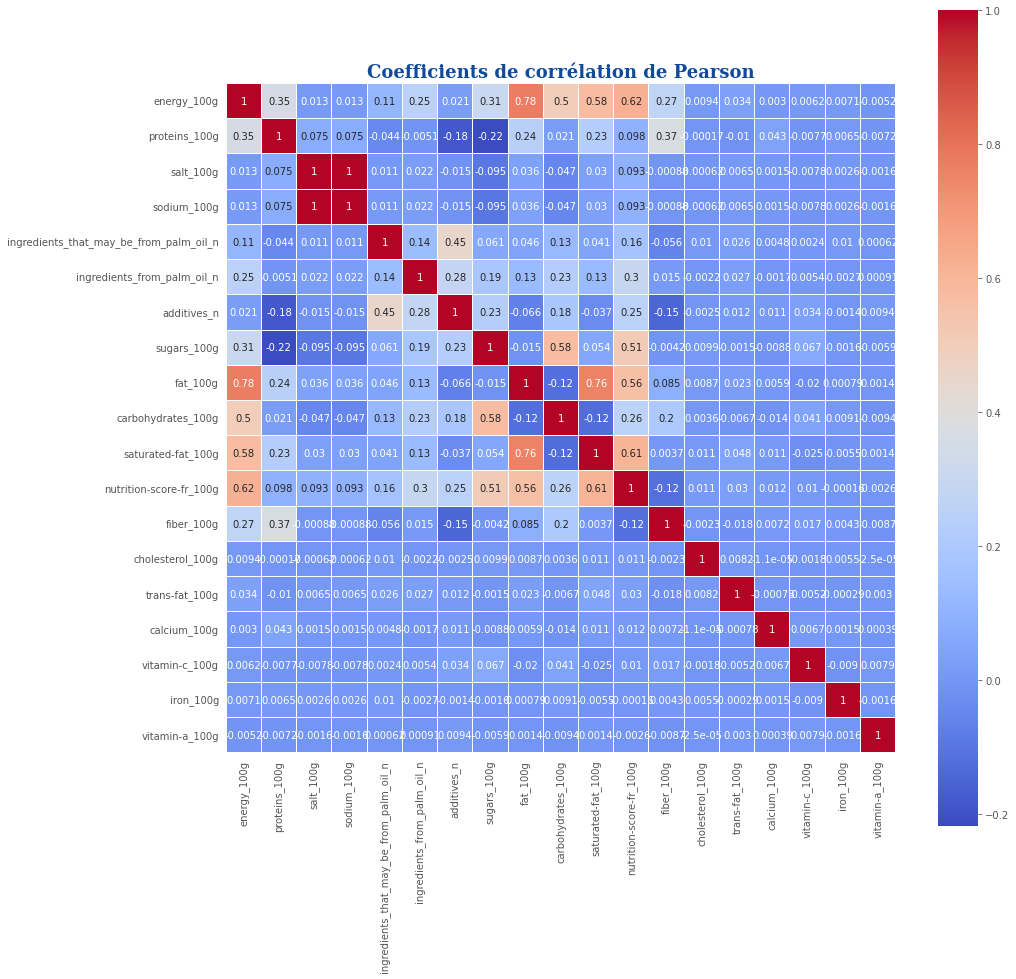

In [77]:
font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

#Matrice des corrélations
corr_mat = df_filtre.corr()
#heatmap
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson", fontdict=font_title)
plt.show()

Notre choix des variables utilisées pour les méthodes d'imputations est basé cette matrice de corrélations. En effet des variables corrélées sont nécessaires pour les algorithmes KNNImputer et IterativeImputer 

In [78]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
colonnes_knn = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g','sodium_100g','additives_n','fat_100g','carbohydrates_100g','fiber_100g']
echantillon = df_filtre[colonnes_knn].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=3, missing_values=np.nan)
imputer.fit(echantillon)

KNNImputer(n_neighbors=3)

In [79]:
# Puis on applique le modèle sur l'ensemble des données
df_impute = imputer.transform(df_filtre[colonnes_knn])
df_impute = pd.DataFrame(df_impute, columns=colonnes_knn)

In [80]:
for col_knn in colonnes_knn:
    df_filtre[col_knn] = df_impute[col_knn].values

In [81]:
df_filtre.isnull().sum().sort_values(ascending=False)


serving_size                               14555
additives_fr                               14074
image_small_url                             7722
image_url                                   7722
ingredients_that_may_be_from_palm_oil_n     3268
ingredients_text                            3268
ingredients_from_palm_oil_n                 3268
nutrition_grade_fr                          2287
nutrition-score-fr_100g                     2287
packaging                                   2106
quantity                                    1250
brands                                        88
product_name                                  74
created_datetime                               1
pnns_groups_2                                  0
pnns_groups_1                                  0
main_category_fr                               0
iron_100g                                      0
vitamin-c_100g                                 0
calcium_100g                                   0
trans-fat_100g      

In [82]:
#On remplace les valeurs manquantes du nom de produit et la marque par un message générique d'indisponibilité
df_filtre['product_name'].fillna(value='Nom du produit indisponible', inplace=True)
df_filtre['brands'].fillna(value='Marque indisponible', inplace=True)

In [83]:
df_filtre.isnull().sum().sort_values(ascending=False)

serving_size                               14555
additives_fr                               14074
image_url                                   7722
image_small_url                             7722
ingredients_from_palm_oil_n                 3268
ingredients_that_may_be_from_palm_oil_n     3268
ingredients_text                            3268
nutrition-score-fr_100g                     2287
nutrition_grade_fr                          2287
packaging                                   2106
quantity                                    1250
created_datetime                               1
vitamin-a_100g                                 0
pnns_groups_2                                  0
vitamin-c_100g                                 0
pnns_groups_1                                  0
categories_fr                                  0
main_category_fr                               0
calcium_100g                                   0
trans-fat_100g                                 0
cholesterol_100g    

Nous devons gerer les valeurs manquantes pour la colonne nutrition-score-fr_100g. Nous allons appliquer la méthode de l'imputation iterative, il s'avère qu'elle fonctionne que pour des variables très correlées. Nous savons que les colonnes suivantes rentrent en ligne de compte pour le calcul du nutriscore : 


*   proteins_100g
*   fiber_100g
*   salt_100g
*   sugars_100g 
*   energy_100g
*   saturated-fat_100g

Nous allons nous servir de ces colonnes pour évaluer les valeurs manquantes du nutriscore




In [84]:
# Imputation itérative
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# On entraine le modèle d'imputation sur un échantillon de données
colonnes_ii = ['nutrition-score-fr_100g', 'energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g', 'fiber_100g']
echantillon = df_filtre[colonnes_ii].sample(frac=0.25, random_state=1)
imputer = IterativeImputer(random_state=42)
imputer.fit(echantillon)

IterativeImputer(random_state=42)

In [85]:
# Puis on applique le modèle sur l'ensemble des données
df_impute = imputer.transform(df_filtre[colonnes_ii])
df_impute = pd.DataFrame(df_impute, columns=colonnes_ii)

In [86]:
for col_ii in colonnes_ii:
    df_filtre[col_ii] = np.round(df_impute[col_ii].values)

In [87]:
def borner(row):
  if row["nutrition-score-fr_100g"] > 40:
    nutriscore = 40
  elif row["nutrition-score-fr_100g"] < -15:
    nutriscore = -15
  else:
    nutriscore = row["nutrition-score-fr_100g"]
  return nutriscore




In [88]:
df_filtre['nutrition-score-fr_100g'] = df_filtre.apply(lambda row: borner(row),axis=1)

Nous allons maintenant gérer les valeurs manquantes de la colonne **nutrition_grade_fr** en se basant sur les valeurs de la colonne **nutrition-score-fr_100g**

In [89]:
def calcul_nutrigrade(row):
  if row["nutrition-score-fr_100g"] < 0 :
    nutrigrade = "a"
  elif ((row["nutrition-score-fr_100g"] >= 0) & (row["nutrition-score-fr_100g"] < 5)) :
    nutrigrade = "b"
  elif ((row["nutrition-score-fr_100g"] >= 5) & (row["nutrition-score-fr_100g"] < 10)) :
    nutrigrade = "c"
  elif ((row["nutrition-score-fr_100g"] >= 10) & (row["nutrition-score-fr_100g"] < 20)) :
    nutrigrade = "d"
  else:
    nutrigrade = "e"
  return nutrigrade

In [90]:
df_filtre['nutrition_grade_fr'] = df_filtre.apply(lambda row: calcul_nutrigrade(row),axis=1)

In [91]:
df_gs = df_filtre[['nutrition-score-fr_100g','nutrition_grade_fr']]
df_gs.sample(20)

,nutrition-score-fr_100g,nutrition_grade_fr
204526,-9.0,a
276216,-3.0,a
182788,15.0,d
301789,-5.0,a
237878,-2.0,a
224003,2.0,b
226368,9.0,c
207859,24.0,e
213401,-1.0,a
275359,11.0,d


In [92]:
df_filtre.isnull().sum().sort_values(ascending=False)

serving_size                               14555
additives_fr                               14074
image_small_url                             7722
image_url                                   7722
ingredients_text                            3268
ingredients_that_may_be_from_palm_oil_n     3268
ingredients_from_palm_oil_n                 3268
packaging                                   2106
quantity                                    1250
created_datetime                               1
pnns_groups_2                                  0
vitamin-a_100g                                 0
nutrition_grade_fr                             0
vitamin-c_100g                                 0
main_category_fr                               0
pnns_groups_1                                  0
categories_fr                                  0
calcium_100g                                   0
trans-fat_100g                                 0
cholesterol_100g                               0
fiber_100g          

In [93]:
df_filtre.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,sugars_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,nutrition-score-fr_100g,fiber_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g
count,30200.000000,30200.000000,30200.000000,30200.000000,26932.000000,26932.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,1240.503344,6.607947,0.655894,0.269579,0.181011,0.098507,1.857406,17.432881,14.555608,34.548599,6.276325,9.105762,2.627219,0.000459,0.002169,0.142330,0.014301,0.007431,0.000200
std,805.078485,6.480629,2.648085,1.034010,0.502364,0.303071,2.496645,20.220967,17.697790,28.280690,9.184369,9.485699,3.671452,0.062797,0.111905,0.458477,0.008398,0.149820,0.000690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,423.000000,2.000000,0.000000,0.011811,0.000000,0.000000,0.000000,2.000000,1.000000,5.930000,0.000000,1.000000,0.000000,0.000000,0.000000,0.130000,0.014000,0.006000,0.000195
50%,1362.000000,6.000000,0.000000,0.082677,0.000000,0.000000,1.000000,8.000000,7.400000,31.500000,2.000000,10.000000,2.000000,0.000000,0.000000,0.130000,0.014000,0.006000,0.000195
75%,1842.000000,9.000000,1.000000,0.354331,0.000000,0.000000,3.000000,29.000000,24.000000,60.300000,10.000000,16.000000,4.000000,0.000000,0.000000,0.130000,0.014000,0.006000,0.000195
max,3700.000000,93.000000,100.000000,39.370079,5.000000,2.000000,31.000000,100.000000,100.000000,100.000000,100.000000,40.000000,86.000000,10.900000,17.200000,69.500000,1.200000,25.000000,0.120000


In [94]:
#Nous allons supprimer les colonnes suivantes parce qu'elles ne sont soit pas pertinentes soit contiennent que des valeurs égales à 0
colonnes_a_supprimer = ['ingredients_that_may_be_from_palm_oil_n','ingredients_from_palm_oil_n','cholesterol_100g','trans-fat_100g','serving_size','additives_fr','image_url','image_small_url','ingredients_text','packaging','quantity']
df_filtre = df_filtre.drop(colonnes_a_supprimer, axis = 1)

In [95]:
df_filtre.isnull().sum().sort_values(ascending=False)

created_datetime           1
last_modified_datetime     0
fat_100g                   0
categories_fr              0
pnns_groups_1              0
pnns_groups_2              0
vitamin-a_100g             0
iron_100g                  0
vitamin-c_100g             0
calcium_100g               0
fiber_100g                 0
nutrition_grade_fr         0
nutrition-score-fr_100g    0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
creator                    0
additives_n                0
sodium_100g                0
salt_100g                  0
proteins_100g              0
energy_100g                0
brands                     0
product_name               0
countries_fr               0
states_fr                  0
url                        0
code                       0
main_category_fr           0
dtype: int64

Après avoir toutes les différentes méthodes de gestion de valeurs manquantes et abérrantes, notre dataset a la forme suivante

In [96]:
df_filtre.shape

(30200, 29)

Npous allons refaire les graphes des distributions des variables et les comparées aux graphes avant les méthodes de gestion de valeurs manquantes et abérrantes.

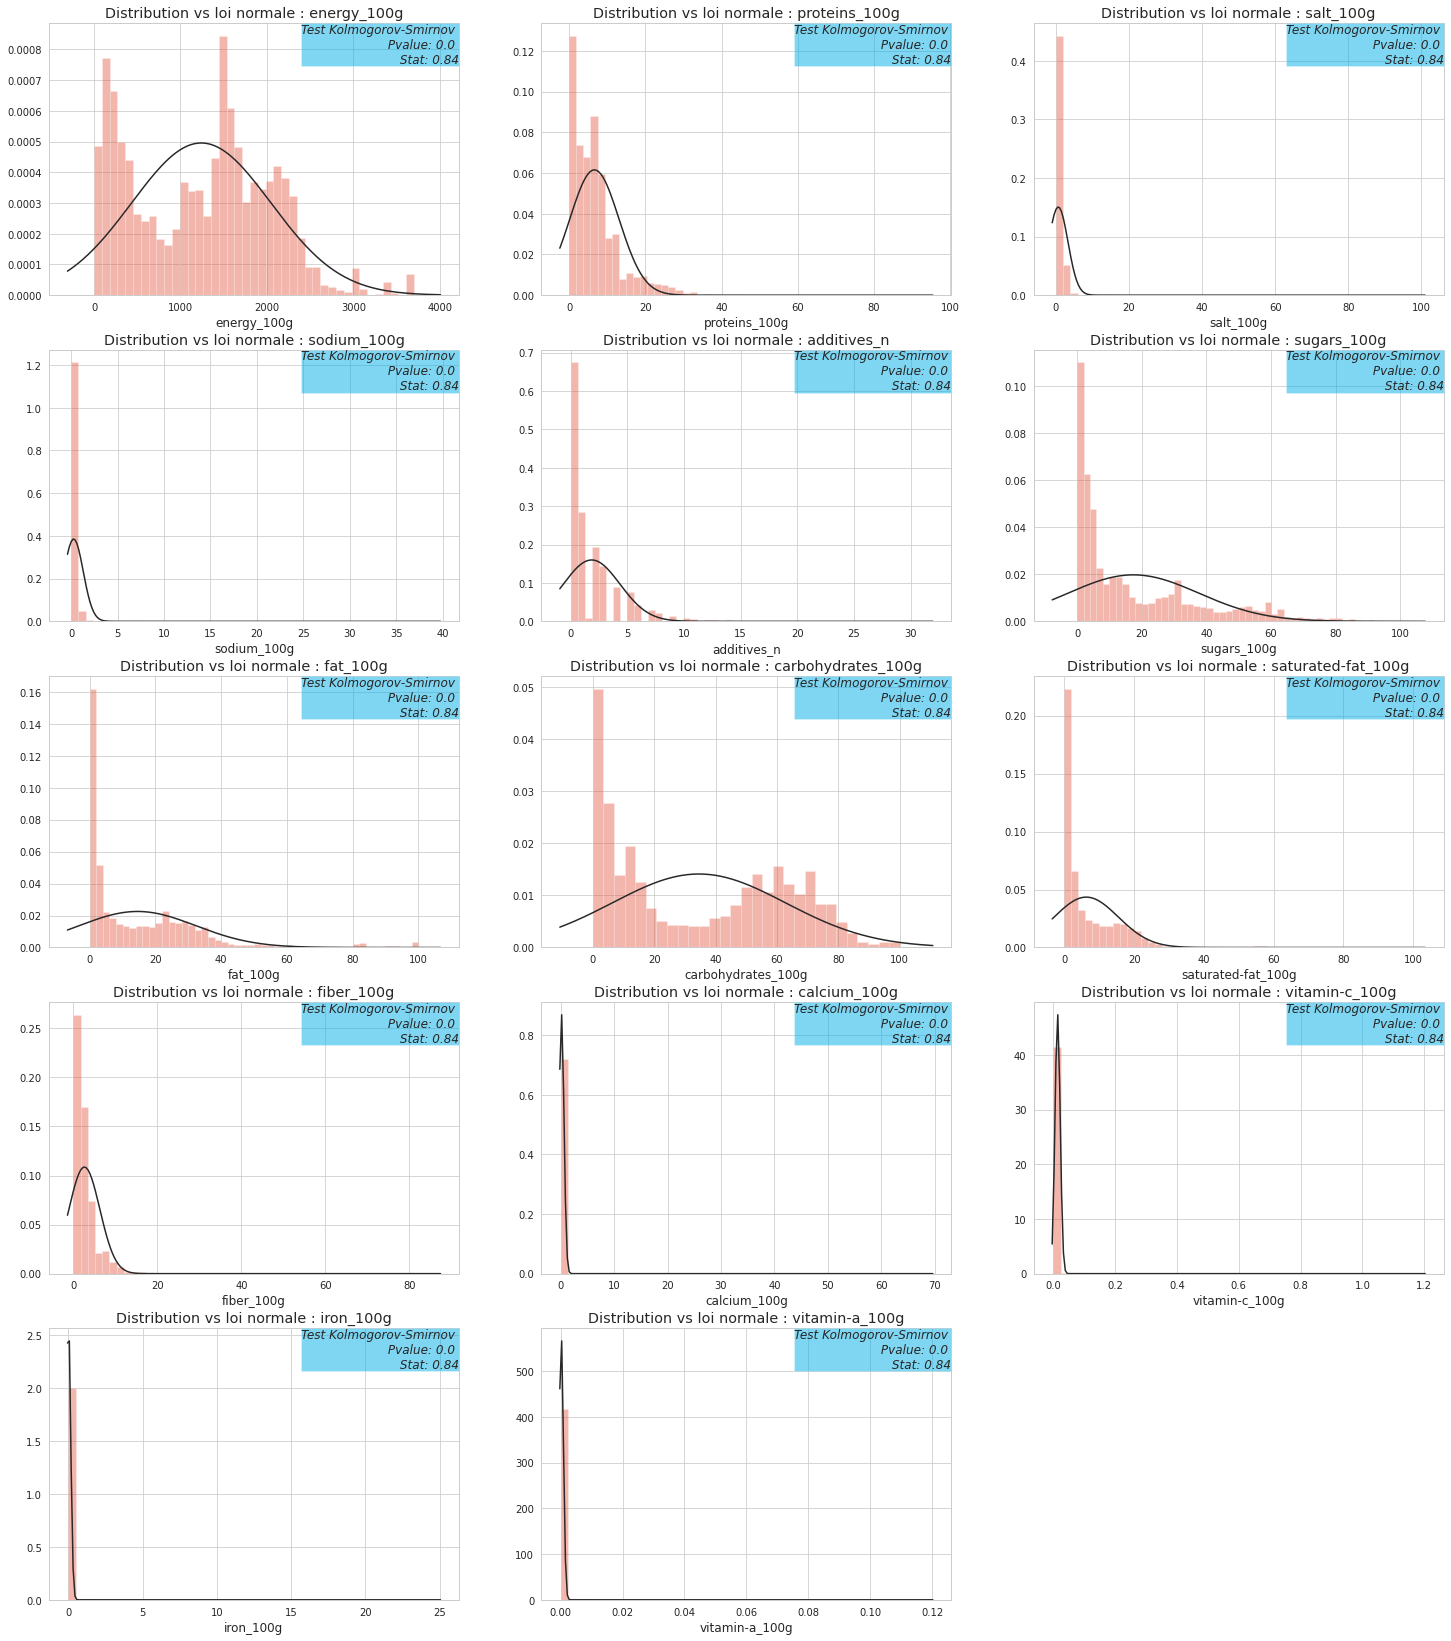

In [97]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(25,35))

colonnes_numeric.remove('ingredients_that_may_be_from_palm_oil_n')
colonnes_numeric.remove('ingredients_from_palm_oil_n')
colonnes_numeric.remove('cholesterol_100g')
colonnes_numeric.remove('trans-fat_100g')


sub = 0
for i in range(len(colonnes_numeric)):
    fig.add_subplot(6,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height

    colonne = colonnes_numeric[i]
    kstest = stats.kstest(df_filtre[colonne].notnull(),'norm')
    ax = sns.distplot(df_filtre[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
plt.show()

Nous nous rendons compte que les différentes méthode d'imputation des valeurs manquantes n'ont pas modofier la distribution des variables du dataset. Nous sauvegardons par la suite le dataset dans un fichier csv pour l'analyse exploratoire.

In [98]:
#Sauvegarde du dataset dans un csv
df_filtre.set_index("code").to_csv("clean-data.csv", sep='\t')